# Training on Text+Audio features

In [1]:
# !pip install tensorflow-text
# !pip install bert-tensorflow
# !pip install tf-models-official

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, tensorflow as tf, tensorflow_hub as hub, tensorflow_text as text, numpy as np, pandas as pd
from sklearn.metrics import classification_report, roc_curve, det_curve, precision_recall_curve, roc_auc_score, accuracy_score,confusion_matrix

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.models as models
from tensorflow.keras.utils import to_categorical
from classificationreport import ClassificationReport ## this is a python script provided in the directory
from tensorflow.keras.losses import CategoricalCrossentropy

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
import csv
import statistics
from sklearn.utils import resample



Since while using Audio-only features, we obtained better results when using MFCCs, we use these to build our final Multimodal model.

In [5]:
x_train_mfcc = np.load('/content/drive/MyDrive/emotion/train_mfccs.npy')
x_test_mfcc = np.load('/content/drive/MyDrive/emotion/test_mfccs.npy')

x_train_mfcc.shape, x_test_mfcc.shape

((9988, 40, 107), (2610, 40, 107))

In [6]:
train_df = pd.read_csv("/content/drive/MyDrive/emotion/train_sent_emo.csv", encoding='latin1')
test_df = pd.read_csv("/content/drive/MyDrive/emotion/test_sent_emo.csv", encoding='latin1')

train_df.shape, test_df.shape

((9988, 11), (2610, 11))

The emotions are labeled by any of these seven emotions -- Anger, Disgust, Sadness, Joy, Neutral, Surprise and Fear. Machine learning models typically work with numerical data, so we need to do Label encoding which converts categorical labels into numeric values, allowing the model to process and learn from them.

In [7]:
le = LabelEncoder()

train_df['emotion_encoded'] = le.fit_transform(train_df['Emotion'])
test_df['emotion_encoded'] = le.transform(test_df['Emotion'])
class_names_encoded = le.classes_

y_train = train_df['Emotion']
y_train_encoded = train_df['emotion_encoded']

y_test = test_df['Emotion']
y_test_encoded = test_df['emotion_encoded']

In [8]:
x_train_text = train_df['Utterance']
x_test_text = test_df['Utterance']

In [9]:
len(max(train_df['Utterance'], key=len)), len(max(test_df['Utterance'], key=len))

(327, 236)

In [10]:
x_train_audio = np.expand_dims(x_train_mfcc, -1)
x_test_audio = np.expand_dims(x_test_mfcc, -1)

In [11]:
train_Y = to_categorical(np.array(y_train_encoded))
test_Y = to_categorical(np.array(y_test_encoded))

In [12]:
class_names_encoded.shape

(7,)

The final shapes of the audio training feature set and the text training feature set are given below - 

In [13]:
x_train_audio.shape, x_train_text.shape

((9988, 40, 107, 1), (9988,))

We load the BERT text preprocessing model from TensorFlow Hub. The BERT model for English text, with uncased vocabulary, and version 3 is used. The `hub.KerasLayer` allows the model to be used as a Keras layer within the TensorFlow framework. The purpose of this preprocessing model is to tokenize and preprocess the input text to be compatible with BERT's input requirements. 
<br>
Then we load the BERT encoder model from TensorFlow Hub. The BERT base model for English text, with an uncased vocabulary, 12 layers, 768 hidden units, and 12 attention heads is used. This model is responsible for encoding the preprocessed text into meaningful representations or embeddings. 

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

### Text-only model - 

In [16]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs_text = bert_encoder(preprocessed_text)
LSTM_Layer = tf.keras.layers.LSTM(units=128)(outputs_text['sequence_output'])
outputLayer_text = tf.keras.layers.Dropout(0.1, name="dropout")(LSTM_Layer)
classification_model_text = Model(text_input, outputLayer_text)
classification_model_text.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classification_model_text.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

Audio-only model - 

In [24]:
inputLayer_audio = Input(shape=x_train_audio[0].shape)

CONV_audio = Conv2D(32, kernel_size=(7, 7), padding='same')(inputLayer_audio)
CONV_audio = BatchNormalization(axis=1)(CONV_audio)
CONV_audio = Activation('relu')(CONV_audio)
CONV_audio = MaxPooling2D(pool_size=2)(CONV_audio)
CONV_audio = Dropout(0.2)(CONV_audio)

CONV_audio = Conv2D(64, kernel_size=(7, 7), padding='same')(CONV_audio)
CONV_audio = BatchNormalization(axis=1)(CONV_audio)
CONV_audio = Activation('relu')(CONV_audio)
CONV_audio = MaxPooling2D(pool_size=2)(CONV_audio)
CONV_audio = Dropout(0.20)(CONV_audio)

CONV_audio = Conv2D(128, kernel_size=(7, 7), padding='same')(CONV_audio)
CONV_audio = BatchNormalization(axis=1)(CONV_audio)
CONV_audio = Activation('relu')(CONV_audio)
CONV_audio = MaxPooling2D(pool_size=2)(CONV_audio)
CONV_audio = Dropout(0.20)(CONV_audio)

CONV_audio = Conv2D(256, kernel_size=(7, 7), padding='same')(CONV_audio)
CONV_audio = BatchNormalization(axis=1)(CONV_audio)
CONV_audio = Activation('relu')(CONV_audio)
CONV_audio = MaxPooling2D(pool_size=2)(CONV_audio)
CONV_audio = Dropout(0.20)(CONV_audio)

FLATTEN_audio = Flatten()(CONV_audio)
DENSE_audio = Dense(128, activation='relu')(FLATTEN_audio)
outputLayer_audio = Dropout(0.20)(DENSE_audio)

classification_model_audio = Model(inputLayer_audio, outputLayer_audio)

print(classification_model_audio.summary())

classification_model_audio.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy']) 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 107, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 107, 32)       1600      
                                                                 
 batch_normalization_4 (Batc  (None, 40, 107, 32)      160       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 40, 107, 32)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 53, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 20, 53, 32)        0   

In [27]:
tf.config.run_functions_eagerly(True)

Since the zip file of the validation set provided with the MELD dataset was corrupted, we created our own validation split from the train data.

In [28]:
from sklearn.model_selection import train_test_split

X_train_audio, X_valid_audio, Y_train, Y_valid = train_test_split(x_train_audio, train_Y, test_size=0.2, random_state=42)
X_train_text, X_valid_text, Y_train, Y_valid = train_test_split(x_train_text, train_Y, test_size=0.2, random_state=42)

In [29]:
type = '/content/drive/MyDrive/emotion/multimodal'

In [30]:
checkpoint = ModelCheckpoint(type + '.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience=10, mode = "max", restore_best_weights = True, verbose=1)

In [22]:
from keras.layers import Concatenate

Finally, we concatenate the last layers before the Dense layer of the Audio and Text models and create a concatenated model which takes both feature sets as input and predicts the emotions from them.

In [26]:
concatenate = Concatenate()([outputLayer_audio, outputLayer_text])
y_predict_emotions = Dense(7, activation='softmax')(concatenate)
model = Model(inputs=[inputLayer_audio, text_input], outputs=y_predict_emotions)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 107, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 40, 107, 32)  1600        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 40, 107, 32)  160        ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [31]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [32]:
model.fit([X_train_audio, X_train_text], Y_train, batch_size=32, epochs=100, callbacks=[checkpoint, es],
                                verbose=1, validation_data=([X_valid_audio, X_valid_text], Y_valid), shuffle=True)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.5849
Epoch 1: val_accuracy improved from -inf to 0.60460, saving model to /content/drive/MyDrive/emotion/multimodal.h5
250/250 [==============================] - 305s 1s/step - loss: 1.2568 - accuracy: 0.5849 - val_loss: 1.2373 - val_accuracy: 0.6046
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.1320 - accuracy: 0.6242
Epoch 2: val_accuracy improved from 0.60460 to 0.62262, saving model to /content/drive/MyDrive/emotion/multimodal.h5
250/250 [==============================] - 287s 1s/step - loss: 1.1320 - accuracy: 0.6242 - val_loss: 1.1517 - val_accuracy: 0.6226
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.6319
Epoch 3: val_accuracy did not improve from 0.62262
250/250 [==============================] - 277s 1s/step - loss: 1.0962 - accuracy: 0.6319 - val_loss: 1.1884 - val_accuracy: 0.5806
Epoch 4/100
250/250 [==========

In [36]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/emotion/multimodal.h5', custom_objects={'KerasLayer':hub.KerasLayer})


The Loss and Accuracy of the trained model on the test set is given below - 

In [38]:
test_loss, test_acc = model.evaluate([x_test_audio, x_test_text], test_Y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

82/82 [==============================] - 32s 388ms/step - loss: 1.1066 - accuracy: 0.6253
Test loss: 1.106624960899353
Test accuracy: 0.6252873539924622


In [40]:
y_pred = model.predict([x_test_audio, x_test_text])
y_pred = np.argmax(y_pred, axis=1)

82/82 [==============================] - 31s 376ms/step


In [41]:
y_test_encoded = np.argmax(test_Y, axis=1)

In [42]:
print(classification_report(y_test_encoded, y_pred, target_names=class_names_encoded))

              precision    recall  f1-score   support

       anger       0.51      0.41      0.46       345
     disgust       0.00      0.00      0.00        68
        fear       0.29      0.04      0.07        50
         joy       0.58      0.45      0.50       402
     neutral       0.66      0.92      0.77      1256
     sadness       0.54      0.10      0.16       208
    surprise       0.57      0.49      0.53       281

    accuracy                           0.63      2610
   macro avg       0.45      0.34      0.36      2610
weighted avg       0.59      0.63      0.58      2610



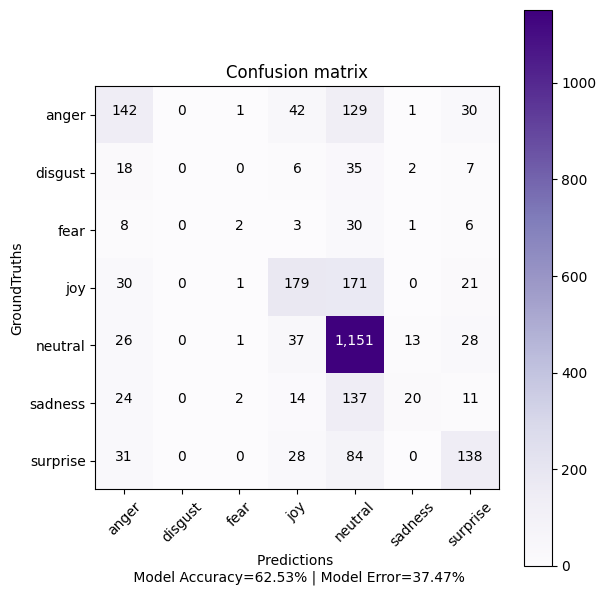

In [43]:
cm = confusion_matrix(y_test_encoded, y_pred)
cr = ClassificationReport()
cr.plot_confusion_matrix(cm=cm, normalize = False, target_names = class_names_encoded)